In [1]:
import torch
import torch.optim
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import TensorDataset,DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.models as models
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import os
#读取数据
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.__version__

'1.1.0'

In [2]:
#*************************************数据集的设置************************************
root =os.getcwd()+ '/lmdb_source_data/'#数据集的地址
print(root)
#先建立一个总的list-->numpy型的，然后
txt = root+'depth2_list2.txt'#depth2_list2，有1100个数据 depth2_list，有1104个数据
x,y=[],[]
fh = open(txt,'r')
for line in fh: #迭代该列表#按行循环txt文本中的内
    line = line.strip('\n')
    line = line.rstrip('\n')# 删除 本行string 字符串末尾的指定字符，这个方法的详细介绍自己查询python
    words = line.split()#用split将该行分割成列表  split的默认参数是空格，所以不传递任何参数时分割空格
    x.append(words[0])
    y.append(int(words[1]))
    #把txt里的内容读入imgs列表保存，具体是words几要看txt内容而定 
    # 很显然，根据我刚才截图所示txt的内容，words[0]是图片信息，words[1]是lable  

/home/asber/Documents/RobotLearning/lmdb_source_data/


In [3]:
train_x,test_x,train_y,test_y = train_test_split(x,y,test_size=0.2,random_state=42)

In [4]:
def default_loader(path):
        return Image.open(path)# 如果是我们的depth map 图片格式是L——灰度图。
    
class MyDataset(Dataset): 
#创建自己的类： MyDataset,这个类是继承的torch.utils.data.Dataset
     def __init__(self,x,y, transform=None,target_transform=None, loader=default_loader):
        super(MyDataset,self).__init__()#对继承自父类的属性进行初始化
        self.x = x
        self.y = y
        self.transform = transform
        self.target_transform = target_transform
        self.loader = loader
        #*************************** #使用__getitem__()对数据进行预处理并返回想要的信息**********************
     def __getitem__(self, index):#这个方法是必须要有的，用于按照索引读取每个元素的具体内容
            fn, label = self.x[index],self.y[index]
            img = self.loader(root+'depth2/'+fn)# 按照路径读取图片
            if self.transform is not None:
                img = self.transform(img)/180.0#数据标签转换为Tensor
            return img,label#return回哪些内容，那么我们在训练时循环读取每个batch时，就能获得哪些内容
     def __len__(self):#这个函数也必须要写，它返回的是数据集的长度，也就是多少张图片，要和loader的长度作区分
            return len(self.x)

In [5]:
train_data=MyDataset(x=train_x,y=train_y, transform=transforms.ToTensor())
test_data=MyDataset(x=test_x,y=test_y, transform=transforms.ToTensor())
print len(train_data),len(test_data)

880 220


In [6]:
train_data_loader = DataLoader(dataset=train_data,batch_size=10,shuffle=False,num_workers=2)
test_data_loader = DataLoader(dataset=test_data,batch_size=10,shuffle=False,num_workers=2)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layers1 = nn.Sequential(
            nn.Conv2d(1,32,kernel_size=5,stride=1,padding=2),#1代表1个通道 32代表kernel数，kernelsize代表大小
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.layers2 = nn.Sequential(
            nn.Conv2d(32,32,kernel_size=5,stride=1,padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.layers3 = nn.Sequential(
            nn.Conv2d(32,64,kernel_size=5,stride=1,padding=2),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.fc = nn.Sequential(
            nn.Linear(20*15*64,300),
            nn.ReLU(inplace=True),
            nn.Linear(300,5),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        x = self.layers1(x)
        x = self.layers2(x)
        x = self.layers3(x)
        x = x.view(x.size(0),-1)
        x = self.fc(x)
        return x

In [7]:
cnn = CNN()

error = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(cnn.parameters(),lr=0.00001)

In [8]:
len(test_data_loader),len(train_data_loader)

(22, 88)

In [9]:
accuracy_list = []
for epochs in range(50):
    for i ,(img,label) in enumerate(train_data_loader):
        img = img.view(10,1,160,120)
        img = Variable(img)
        label = Variable(label)
        optimizer.zero_grad()
        output = cnn(img)
        
        loss = error(output,label)
        loss.backward()

        optimizer.step()

        if i %10 == 0:
            accuracy = 0
            for x,y in test_data_loader:
                x = x.view(10,1,160,120)
                x = Variable(x)
                out = cnn(x)
                pre = torch.max(out.data,1)[1]
                accuracy += (pre == y).sum()
            
            print('accuracy:',accuracy.item()/(220.0))
            accuracy_list.append(accuracy.item()/(220.0))
            if(accuracy.item()/(220.0)>0.5):
                torch.save(cnn.state_dict(),'./abcd.pth')
            if(accuracy.item()/220.0 >= 0.51):
                break

('accuracy:', 0.2409090909090909)
('accuracy:', 0.25)
('accuracy:', 0.2545454545454545)
('accuracy:', 0.2590909090909091)
('accuracy:', 0.2727272727272727)
('accuracy:', 0.2772727272727273)
('accuracy:', 0.2772727272727273)
('accuracy:', 0.2772727272727273)
('accuracy:', 0.2772727272727273)
('accuracy:', 0.2818181818181818)
('accuracy:', 0.2863636363636364)
('accuracy:', 0.2863636363636364)
('accuracy:', 0.2863636363636364)
('accuracy:', 0.2863636363636364)
('accuracy:', 0.2909090909090909)
('accuracy:', 0.2863636363636364)
('accuracy:', 0.2909090909090909)
('accuracy:', 0.2909090909090909)
('accuracy:', 0.2909090909090909)
('accuracy:', 0.3)
('accuracy:', 0.29545454545454547)
('accuracy:', 0.2909090909090909)
('accuracy:', 0.29545454545454547)
('accuracy:', 0.30454545454545456)
('accuracy:', 0.3090909090909091)
('accuracy:', 0.31363636363636366)
('accuracy:', 0.31363636363636366)
('accuracy:', 0.31363636363636366)
('accuracy:', 0.31363636363636366)
('accuracy:', 0.3090909090909091)
('

('accuracy:', 0.39090909090909093)
('accuracy:', 0.38636363636363635)
('accuracy:', 0.38181818181818183)
('accuracy:', 0.38636363636363635)
('accuracy:', 0.38636363636363635)
('accuracy:', 0.39090909090909093)
('accuracy:', 0.39090909090909093)
('accuracy:', 0.39090909090909093)
('accuracy:', 0.39090909090909093)
('accuracy:', 0.39090909090909093)
('accuracy:', 0.38181818181818183)
('accuracy:', 0.38181818181818183)
('accuracy:', 0.38636363636363635)
('accuracy:', 0.38636363636363635)
('accuracy:', 0.39090909090909093)
('accuracy:', 0.39545454545454545)
('accuracy:', 0.39090909090909093)
('accuracy:', 0.39545454545454545)
('accuracy:', 0.38636363636363635)
('accuracy:', 0.38181818181818183)
('accuracy:', 0.38181818181818183)
('accuracy:', 0.39090909090909093)
('accuracy:', 0.39090909090909093)
('accuracy:', 0.39090909090909093)
('accuracy:', 0.39090909090909093)
('accuracy:', 0.39090909090909093)
('accuracy:', 0.39090909090909093)
('accuracy:', 0.39090909090909093)
('accuracy:', 0.3863

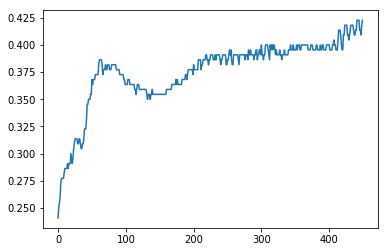

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(accuracy_list)
plt.show()